# Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import json
import pickle
import ast
from geopy import distance
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})
from collections import Counter
import calendar
from datetime import datetime, timedelta

# statistical
from sklearn.neighbors import KernelDensity

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

base_path = '/content/gdrive/MyDrive/complexsystems/'

Mounted at /content/gdrive


# Functions

In [3]:
def transform_data(df):
  df = df.copy().dropna()
  # df['started_at_round'] = pd.to_datetime(df['time1'], errors='coerce').dt.floor(str(gen_update)+'T')
  # df['ended_at_round'] = pd.to_datetime(df['time2'], errors='coerce').dt.floor(str(gen_update)+'T')
  # df['start'] = df['started_at_round'].dt.strftime('%H:%M')
  # df['end'] = df['ended_at_round'].dt.strftime('%H:%M')
  
  df['started_at_round'] = pd.to_datetime(df['time1'], errors='coerce')
  df['ended_at_round'] = pd.to_datetime(df['time2'], errors='coerce')
  df['start'] = df['started_at_round'].dt.strftime('%H:%M')
  df['end'] = df['ended_at_round'].dt.strftime('%H:%M')
  
  df['day'] = df['started_at_round'].dt.date
  df['month'] = df['started_at_round'].dt.month
  df['week'] = df['started_at_round'].dt.isocalendar().week
  df['weekday'] = df['started_at_round'].dt.dayofweek

  df['season'] = df['started_at_round'].dt.month % 12 // 3 + 1 # le raggruppa a inizio mese, non nella data precisa
  df['weekend'] = df['started_at_round'].dt.dayofweek > 4
  df['hour_group'] = regroup_values(list(df['started_at_round'].dt.hour), 3)
  return df

In [4]:
# def find_by(df, start, weekday, month, station_start=None, station_end=None, min_limit=2):
#   query = df.copy()

#   if start:
#     query = query[(query['start'] == start)]
#   if weekday:
#     query = query[(query['weekday'] == weekday)]
#   if month:
#     query = query[(query['month'] == month)]
  
#   if station_start:
#     query = query[query['id1'] == station_start]
#   if station_end:
#     query = query[query['id2'] == station_end]
  
#   if (not station_start) and (not station_end):
#     start_stat_id = Counter(query['id1'])
#     stat_ids = [x for x in start_stat_id if start_stat_id[x] > min_limit]
#     query = query[query['id1'].isin(stat_ids)]
  
#   return query

def find_by(df, season, weekend, hour_group, station_start=None, station_end=None, min_limit=2):
  query = df.copy()

  if season:
    query = query[(query['season'] == season)]
  if weekend:
    query = query[(query['weekend'] == weekend)]
  if hour_group:
    query = query[(query['hour_group'] == hour_group)]
  
  if station_start:
    query = query[query['id1'] == station_start]
  if station_end:
    query = query[query['id2'] == station_end]
  
  if (not station_start) and (not station_end):
    start_stat_id = Counter(query['id1'])
    stat_ids = [x for x in start_stat_id if start_stat_id[x] > min_limit]
    query = query[query['id1'].isin(stat_ids)]
  
  return query

In [5]:
# into intervals of size n
def regroup_values(values, n):
  return [n*(h//n) for h in values]

In [6]:
def convert_hour_to_float(x):
  hour, minutes = x.split(':')
  conv = lambda x: x  + (x * (2/3))
  return float(hour) + (conv(float(minutes)/100))

In [7]:
def normalize_probabilities(data):
  """
  takes list of probabilities
  returns list of probabilities which sums to 1
  """
  return data / np.sum(data)

In [8]:
def filter_prob(station_probs, threshold=3/4):
  probs = list(station_probs.values())
  station_probs_filter = {station: probs[i] for i, station in enumerate(station_probs) if probs[i] > np.quantile(probs, threshold)}
  probs_norm = normalize_probabilities(list(station_probs_filter.values()))
  return {str(station): probs_norm[i] for i, station in enumerate(station_probs_filter)}

In [9]:
def get_stations_size(seed, total_bikes, station_ids, delete_station_id=None):
  """
  Assign starting number of bikes to each station, proportionally to their dock size
  """
  np.random.seed(seed)

  # max concurrent parked bikes for each station
  dock_sizes = pd.read_csv(base_path+'data/stats/san_jose/max_parked_bikes_by_station.csv').set_index('id').to_dict()['max_parked_bikes']
  if delete_station_id:
    del dock_sizes[delete_station_id]

  # convert count into probabilities
  probs = normalize_probabilities(np.array(list(dock_sizes.values())) / np.sum(list(dock_sizes.values())))

  # given the probabilities, generate random bike assignments to stations
  r = [np.random.choice(list(dock_sizes.keys()), p=probs) for i in range(total_bikes)]
  dock_sizes = pd.value_counts(r).to_dict()

  # set 0 if no bikes were assigned
  for _id in station_ids:
    if _id not in dock_sizes:
      dock_sizes[_id] = 0
  return dock_sizes

In [10]:
# # def find_from(df, from_time, to_time, weekday=None, month=None, station_start=None, station_end=None, min_limit=2):
# #   query = df.copy()

# #   query = query.set_index('started_at_round')

# #   if weekday:
# #     query = query[(query['weekday'] == weekday)]
# #   if month:
# #     query = query[(query['month'] == month)]

# #   query = query.between_time(from_time, to_time)
  
# #   if station_start:
# #     query = query[query['id1'] == station_start]
# #   if station_end:
# #     query = query[query['id2'] == station_end]
    
# #   if (not station_start) and (not station_end):
# #     start_stat_id = Counter(query['id1'])
# #     stat_ids = [x for x in start_stat_id if start_stat_id[x] > min_limit]
# #     query = query[query['id1'].isin(stat_ids)]

# #   query = query.reset_index()
# #   return query


# def find_from(df, from_time, to_time, season=None, weekend=None, station_start=None, station_end=None, min_limit=2):
#   query = df.copy()

#   query = query.set_index('started_at_round')

#   if season:
#     query = query[(query['season'] == season)]
#   if weekend:
#     query = query[(query['weekend'] == weekend)]

#   query = query.between_time(from_time, to_time)
  
#   if station_start:
#     query = query[query['id1'] == station_start]
#   if station_end:
#     query = query[query['id2'] == station_end]
    
#   if (not station_start) and (not station_end):
#     start_stat_id = Counter(query['id1'])
#     stat_ids = [x for x in start_stat_id if start_stat_id[x] > min_limit]
#     query = query[query['id1'].isin(stat_ids)]

#   query = query.reset_index()
#   return query

In [11]:
# def station_probability(df, start_station, end_station, gen_update, season=None, weekend=None, hour_group=None):
#   data = np.expand_dims([convert_hour_to_float(x) for x in find_by(df, season, weekend, hour_group, start_station, end_station)['start'].values], 1)
  
#   if len(data) == 0:
#     return None
  
#   # ticks
#   start = 0
#   end = 24-convert_hour_to_float('00:'+str(gen_update))
#   freq = int(24 * 60/gen_update)
#   x =  np.expand_dims(np.linspace(start, end, freq), 1)

#   # Do kernel density estimation
#   kd = KernelDensity(kernel='gaussian', bandwidth=1).fit(data)
#   kd_vals = np.exp(kd.score_samples(x))

#   kd_vals_norm = normalize_probabilities(kd_vals)

#   # Plot the estimated density
#   # plt.plot(x, kd_vals, label='og')
#   # plt.plot(x, kd_vals_norm, label='norm')
#   # plt.legend()
#   # plt.show()

#   return {float(x_i): kd_vals_norm[i] for i, x_i in enumerate(x)}

In [12]:
# def get_duration_feasibility(df, start, weekday, month, station_start, station_end, tick=5): 
#   """
#   get probabilities of how feasible the trip from A to B is (for each tick) 
#   """
#   data = np.expand_dims(find_by(df, start, weekday, month, station_start, station_end)['duration'].values, 1)

#   if len(data) == 0: # never seen trip
#     return None

#   right_max = max(data) + np.mean(data) # per spostare un po' a destra (outliers fino a 150%)

#   right_max_rounded = int(tick * np.ceil(np.floor(right_max) / tick))

#   tick_rate = 1 # SMOOTH FACTOR: aumenta per avere piu' punti (se serve avere tick piu' piccoli) e.g. 5 tick -> rate 2 = 2.5 tick
#   distance_tick = int((right_max_rounded / tick ) * tick_rate) + 1
  
#   # ticks
#   x =  np.expand_dims(np.linspace(0, right_max_rounded, distance_tick), 1)

#   # Do kernel density estimation
#   kd = KernelDensity(kernel='gaussian', bandwidth=1).fit(data)
#   kd_vals = np.exp(kd.score_samples(x))

#   kd_vals_norm = normalize_probabilities(kd_vals)

#   # Plot the estimated density
#   #plt.plot(x, kd_vals)
#   #plt.show()

#   return {int(x_i): kd_vals_norm[i] for i, x_i in enumerate(x)}

In [13]:
# def generate_outgoing_bikes(df, station_start, _datetime, gen_update):
#   """
#   generate random number of bikes leaving a station in a given tuple (HH:MM, weekday, month)
#   using probability distribution over observed data in previous scenarios
#   """
#   start = _datetime.strftime('%H:%M')#[0]
#   weekday = _datetime.weekday()#[0]
#   month = _datetime.month

#   to_start = get_time(start, gen_update) 
#   query = find_from(df, start, to_start, weekday, month, station_start.id, None)

#   if len(query) == 0: # no data available
#     return 0 # assuming that if didn't happen in two entire years, it will never happen

#   """
#   need to add zeros for weeks not present in data = days when no bikes where used
#   otherwise I will only look at weeks in which at least a bike left the station, 
#   and that does not reflect reality
#   """
#   years = set(query['started_at_round'].dt.year)

#   #print(month, weekday, years)
#   total_weeks = int(np.sum([len([1 for i in calendar.monthcalendar(y, month) if i[weekday] != 0]) for y in years]))
#   query_data = list(query.groupby('week').count()['bike_id'].values)

#   data = query_data + [0 for x in range(total_weeks-len(query_data))]
#   data = np.expand_dims(data, 1)
#   right_max = max(data) + np.mean(data) # per spostare un po' a destra (outliers fino a 150%)

#   # Plot the true distribution
#   x =  np.expand_dims(np.linspace(0, int(right_max), int(np.ceil(right_max))), 1)
  
#   # Do kernel density estimation
#   kd = KernelDensity(kernel='gaussian', bandwidth=1).fit(data)
#   kd_vals = np.exp(kd.score_samples(x))

#   get_prob = {int(x_i): kd_vals[i] for i, x_i in enumerate(x)}
  
#   n_bikes = np.random.choice(list(get_prob.keys()), p=normalize_probabilities(list(get_prob.values())))
#   if n_bikes > len(station_start.available_bikes): 
#     n_bikes = len(station_start.available_bikes)
#   return n_bikes

# Read file

In [14]:
df = pd.read_csv(base_path+'data/preprocessed/preprocessed_data_san_jose.csv', converters={"coords1": ast.literal_eval,"coords2": ast.literal_eval})
len(df)

198333

In [15]:
df = transform_data(df)

In [16]:
STATIONS = set(df['id1']).union(set(df['id2']))

# [SAVE] Save data, to make simulation faster

### Stopping probabilities

In [ ]:
# d = {}

# for season in set(df['season']):
#   tmp1 = df[df['season']==season].copy()
#   d[season] = {}

#   for weekend in set(tmp1['weekend']):
#     tmp2 = tmp1[tmp1['weekend']==weekend].copy()
#     d[season][weekend] = {}

#     for hour_group in set(tmp2['hour_group']):
#       tmp3 = tmp2[tmp2['hour_group']==hour_group].copy()

#       data = [1-len(tmp3[tmp3['duration']>i])/len(tmp3) for i in range(200)]
#       data = [data[0]] + list(np.convolve(data, np.ones(3)/3, mode='valid')) + [data[-1]]

#       d[season][weekend][hour_group] = {i: data[i] for i in range(200)}

# with open(base_path+'data/stopping_probability_dict.pkl', 'wb') as fp:
#     pickle.dump(d, fp)

### Arrival station probabilities

In [ ]:
# def station_probability(data, gen_update):  
#   # ticks
#   start = 0
#   end = 24-convert_hour_to_float('00:'+str(gen_update))
#   freq = int(24 * 60/gen_update)
#   x =  np.linspace(start, end, freq)
#   x = np.around(x, 5)
#   x = np.expand_dims(x, 1)

#   # Do kernel density estimation
#   kd = KernelDensity(kernel='gaussian', bandwidth=1).fit(data)
#   kd_vals = np.exp(kd.score_samples(x))

#   kd_vals_norm = normalize_probabilities(kd_vals)
#   return {str(float(x_i)): kd_vals_norm[i] for i, x_i in enumerate(x)}



# def get_duration_feasibility(data, tick=5): 
#   """
#   get probabilities of how feasible the trip from A to B is (for each tick) 
#   """
#   right_max = max(data) + np.mean(data) # per spostare un po' a destra (outliers fino a 150%)

#   right_max_rounded = int(tick * np.ceil(np.floor(right_max) / tick))

#   tick_rate = 1 # SMOOTH FACTOR: aumenta per avere piu' punti (se serve avere tick piu' piccoli) e.g. 5 tick -> rate 2 = 2.5 tick
#   distance_tick = int((right_max_rounded / tick ) * tick_rate) + 1
  
#   # ticks
#   x =  np.expand_dims(np.linspace(0, right_max_rounded, distance_tick), 1)

#   # Do kernel density estimation
#   kd = KernelDensity(kernel='gaussian', bandwidth=1).fit(data)
#   kd_vals = np.exp(kd.score_samples(x))

#   kd_vals_norm = normalize_probabilities(kd_vals)
#   return {int(x_i): kd_vals_norm[i] for i, x_i in enumerate(x)}



# gen_update = 5
# print('START!')

# for st1 in STATIONS:
#   print('\n', st1, end=': ')
#   tmp1 = df[df['id1']==st1].copy()
#   d = {}

#   for st2 in STATIONS-{st1}:
#     print('.',end='')
#     tmp2 = tmp1[tmp1['id2']==st2].copy()
#     d[st2] = {}

#     for season in [1,2,3,4]:
#       tmp3 = tmp2[tmp2['season']==season].copy()
#       d[st2][season] = {}

#       for weekend in [True, False]: 
#         tmp4 = tmp3[tmp3['weekend']==weekend].copy()
#         d[st2][season][weekend] = {}

#         for hour_group in set(df['hour_group']): 
#           tmp5 = tmp4[tmp4['hour_group']==hour_group].copy()

#           dataF = np.expand_dims([x for x in tmp5['duration'].values], 1)
          
#           if len(dataF) == 0:
#             pf = None
#             ps = None
#           else:
#             dataS = np.expand_dims([convert_hour_to_float(x) for x in tmp5['start'].values], 1)
#             pf = get_duration_feasibility(dataF)
#             ps = station_probability(dataS, gen_update)
          
#           d[st2][season][weekend][hour_group] = {'pf': pf, 'ps': ps}


#   with open(base_path+'data/probabilities_arrival/'+str(st1)+'_probabilities.pkl', 'wb') as fp:
#     pickle.dump(d, fp)

### Departure stations probabilities

In [ ]:
def find_from(df, from_time, to_time):
  query = df.copy()
  query = query.set_index('started_at_round')
  query = query.between_time(from_time, to_time)
  return query.reset_index()



def get_intervals_count():
  d = {}

  for season in [1,2,3,4]: 
    d[season] = {}

    for weekend in [True, False]: 
      x = [datetime(2018,1,1)+timedelta(days=i) for i in range(730)] # 730 because it's 2 years
      x = [d for d in x if d.month % 12 // 3 + 1 == season]
      if weekend:
        x = [d for d in x if d.weekday() > 4]
      else:
        x = [d for d in x if d.weekday() <= 4]

      d[season][weekend] = len(x)

  return d



def count_avg_outgoing_bikes(df, from_time, to_time, tot_intervals):
  query = find_from(df, from_time, to_time)

  if len(query) == 0: # no data available
    return 0 # assuming that if didn't happen in two entire years, it will never happen

  years = set(query['started_at_round'].dt.year)
  query_data = list(query.groupby('day').count()['bike_id'].values)
  
  data = query_data + [0 for x in range(tot_intervals-len(query_data))]
  return np.mean(data)



## PROVA 2 CON POISSON
"""
avg number of bikes leaving a station in a given tuple (HH:MM, weekday, month)
"""
gen_update = 5
print('START!')

intervals_count = get_intervals_count()

for station in STATIONS:
  print(station, end=', ')
  tmp1 = df[df['id1']==station].copy()
  d = {}

  for season in [1,2,3,4]:
    tmp2 = tmp1[tmp1['season']==season].copy()
    d[season] = {}
    
    for weekend in [True, False]:
      tmp3 = tmp2[tmp2['weekend']==weekend].copy()
      d[season][weekend] = {}

      i = datetime(2000,1,1,0,0,0)
      end = datetime(2000,1,2,0,0,0)
      while i < end:
        from_time = i.strftime('%H:%M')
        to_time = (i + timedelta(minutes=gen_update)).strftime('%H:%M')
        tot_intervals = intervals_count[season][weekend]

        d[season][weekend][from_time] = count_avg_outgoing_bikes(tmp3, from_time, to_time, tot_intervals)

        i += timedelta(minutes=gen_update)

  with open(base_path+'data/probabilities_departure/'+str(station)+'_probabilities2.pkl', 'wb') as fp:
    pickle.dump(d, fp)

START!
35, 208, 275, 276, 277, 278, 279, 280, 281, 282, 283, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 316, 317, 318, 327, 341, 357, 374, 378, 388, 389, 391, 392, 393, 394, 395, 396, 397, 401, 402, 403, 404, 405, 406, 407, 415, 416, 417, 418, 421, 422, 423, 425, 426, 427, 442, 443, 444, 470, 472, 473, 475, 476, 491, 494, 495, 

In [ ]:
# def generate_outgoing_bikes(df, from_time, to_time, tot_intervals):
#   query = find_from(df, from_time, to_time)

#   if len(query) == 0: # no data available
#     return 0 # assuming that if didn't happen in two entire years, it will never happen

#   years = set(query['started_at_round'].dt.year)
#   query_data = list(query.groupby('day').count()['bike_id'].values)
  
#   data = query_data + [0 for x in range(tot_intervals-len(query_data))]
#   data = np.expand_dims(data, 1)
  
#   right_max = max(data) + np.mean(data) # per spostare un po' a destra (outliers fino a 150%)

#   # plot the true distribution
#   x = np.expand_dims(np.linspace(0, int(right_max), int(np.ceil(right_max))), 1)

#   # do kernel density estimation
#   kd = KernelDensity(kernel='gaussian', bandwidth=1).fit(data)
#   kd_vals = np.exp(kd.score_samples(x))

#   return {int(x_i): kd_vals[i] for i, x_i in enumerate(x)}



# """
# generate random number of bikes leaving a station in a given tuple (HH:MM, weekday, month)
# using probability distribution over observed data in previous scenarios
# """
# gen_update = 5
# print('START!')

# intervals_count = get_intervals_count()

# for station in STATIONS:
#   print(station, end=', ')
#   tmp1 = df[df['id1']==station].copy()
#   d = {}

#   for season in [1,2,3,4]:
#     tmp2 = tmp1[tmp1['season']==season].copy()
#     d[season] = {}
    
#     for weekend in [True, False]:
#       tmp3 = tmp2[tmp2['weekend']==weekend].copy()
#       d[season][weekend] = {}

#       i = datetime(2000,1,1,0,0,0)
#       end = datetime(2000,1,2,0,0,0)
#       while i < end:
#         from_time = i.strftime('%H:%M')
#         to_time = (i + timedelta(minutes=gen_update)).strftime('%H:%M')
#         tot_intervals = intervals_count[season][weekend]

#         d[season][weekend][from_time] = generate_outgoing_bikes(tmp3, from_time, to_time, tot_intervals)

#         i += timedelta(minutes=gen_update)

#   with open(base_path+'data/probabilities_departure/'+str(station)+'_probabilities.pkl', 'wb') as fp:
#     pickle.dump(d, fp)

### Distance dictionary

In [ ]:
# def get_stations_coords(df):
#   stations_df = df[['id1', 'coords1']].drop_duplicates(['id1'])
#   stations = pd.Series(stations_df.coords1.values,index=stations_df.id1).to_dict()
#   return stations


# def distances2probabilities(distances, threshold): 
#   return list(normalize_probabilities(threshold-np.array(distances)))


# def get_dist_dict(station_coords, threshold): 
#   dist_dict = {}
#   for s1 in station_coords: 

#     # calculate straight-line distance between stations
#     dist_dict[s1] = {s2: distance.distance(station_coords[s1], station_coords[s2]).kilometers for s2 in station_coords if s1 != s2}

#     # threshold with max distance
#     threshed = {k:v for k,v in dist_dict[s1].items() if v < threshold}
    
#     # convert distances into probabilities
#     # if no stations within 500m, just add the closest stations without probabilities
#     if len(threshed) > 0:
#       dist_dict[s1] = {
#         'stations': list(threshed.keys()), 
#         'probs': distances2probabilities(list(threshed.values()), threshold)
#       }
#     else:
#       dist_dict[s1] = [k for k, v in sorted(dist_dict[s1].items(), key=lambda item: item[1])][:10]

#   return dist_dict


# stat_coords = get_stations_coords(df)
# dist_dict = get_dist_dict(stat_coords, 0.5)
# with open(base_path+'data/dist_dict.pkl', 'wb') as fp:
#   pickle.dump(dist_dict, fp)

# Simulation

In [17]:
stop_prob_dict = pickle.load(open(base_path+'data/stopping_probability_dict.pkl', 'rb'))
memory_arrival = {s: pickle.load(open(base_path+'data/probabilities_arrival/'+str(s)+'_probabilities.pkl', 'rb')) for s in STATIONS}
# memory_departure = {s: pickle.load(open(base_path+'data/probabilities_departure/'+str(s)+'_probabilities.pkl', 'rb')) for s in STATIONS}
memory_departure = {s: pickle.load(open(base_path+'data/probabilities_departure/'+str(s)+'_probabilities2.pkl', 'rb')) for s in STATIONS}
dist_dict = pickle.load(open(base_path+'data/dist_dict.pkl', 'rb'))

### Parameters

In [18]:
# PARAMETERS
GEN_UPDATE = 5 # frequency of update in minutes
TOTAL_BIKES = 400
start_date = datetime(2018, 6, 1, 0, 0, 0)
end_date = datetime(2018, 7, 1, 0, 0, 0)
delete_station = None

In [19]:
# real-life number of unique bikes
tmp = df.copy()
tmp['time1'] = pd.to_datetime(tmp['time1'])
tmp['time2'] = pd.to_datetime(tmp['time2'])
tmp = tmp[(tmp['time1']>=start_date) & (tmp['time1']<end_date)].sort_values(by='time1')
len(set(tmp['bike_id']))

371

### Classes definition

In [20]:
class Simulation:

  def __init__(self, df, start_time, end_time, gen_update, station_ids, total_bikes, seed=None, delete_station=None, output_dir=''):

    #create directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)


    # set seed
    if seed is not None:
      self.seed = seed
    else:
      self.seed = int(random.random() * 999)
    np.random.seed(self.seed)

    # setup parameters
    self.df = df
    self.gen_update = gen_update
    self.start_time = start_time
    self.end_time = end_time
    self.cur_time = start_time
    self.total_bikes = total_bikes
    self.station_ids = station_ids
    self.delete_station_id = delete_station
    self.output_dir = output_dir
    self.cur_generation = 0
    self.running_bikes = []
    self.lost_history = []
    dock_sizes = get_stations_size(self.seed, self.total_bikes, self.station_ids, self.delete_station_id)
    self.stations = {_id: Station(_id, dock_sizes[_id]) for _id in station_ids}


  def simulate(self, verbose=True):
    """
    Perform the simulation
    """
    np.random.seed(self.seed)

    if verbose:
      print('START')
    
    while self.cur_time < self.end_time:
      if verbose and self.cur_generation % (24*12*7) == 0:
        print(self.cur_time.date())
      self.update()
      self.add()
      self.cur_time += timedelta(minutes=self.gen_update)
      self.cur_generation += 1
    self.save_data()
    
    if verbose:
      print('FINISH\n')


  def save_data(self): 
    """
    Merge and save the history of every bike
    """
    np.random.seed(self.seed)

    tot_bikes = self.running_bikes
    for station in list(self.stations.values()):
      tot_bikes += station.available_bikes
    histories = self.lost_history
    for bike in tot_bikes:
      for h in bike.history:
        histories.append(h)
    h = pd.DataFrame(histories).sort_values(by='time1')
    h['duration'] = (h['time2'] - h['time1']).dt.seconds / 60
    filename = 'history' 
    filename += '_seed' + str(self.seed) 
    filename += '_start' + self.start_time.strftime('%Y-%m-%d')
    filename += '_end' + self.end_time.strftime('%Y-%m-%d')
    filename += '_station'+str(self.delete_station_id)
    filename += '_bikes'+str(self.total_bikes)
    filename += '.csv'
    h.to_csv(self.output_dir + filename, index=False)


  def update(self):
    """
    Computes next state prediction for each bike
    """
    np.random.seed(self.seed)

    for station in self.stations.values():
      station.update_bikes()
    
    # for each running bike
    for bike in self.running_bikes:

      # update drive time
      bike.drive_time = (self.cur_generation - bike.start_gen) * self.gen_update

      # probability of not stopping
      tmp = df[(df['season']==bike.get_start_season()) & (df['weekend']==bike.get_start_weekend()) & (df['hour_group']==bike.get_start_hour_group())]
      stop_prob = stop_prob_dict[bike.get_start_season()][bike.get_start_weekend()][bike.get_start_hour_group()][bike.drive_time]
      r = np.random.rand(1)[0]
      if r > stop_prob: # doesn't stop
        continue

      # probability of arrival at each station
      station_probs = self.prob_dest_station(bike)
      station_probs = filter_prob(station_probs, threshold=3/4)

      # choose station
      if not station_probs: # if probability for each station is zero
        pred_station = int(np.random.choice(list(self.station_ids)))
      else: 
        pred_station = int(np.random.choice(list(station_probs.keys()), p=normalize_probabilities(list(station_probs.values()))))

      # if delete-station scenario, change station by distance
      changed = False
      if pred_station == self.delete_station_id: 
        changed = True
        alternative = dist_dict[pred_station]
        if 'probs' in alternative: # there are stations within 500m
          pred_station = np.random.choice(alternative['stations'], p=alternative['probs'])
        else: 
          pred_station = alternative['stations'][0]

      # stop bike
      bike.stop(self.cur_time, pred_station, changed)
      self.stations[pred_station].arrive(bike)

    # remove bikes if arrived
    self.running_bikes = [bike for bike in self.running_bikes if bike.is_running()]
      

  def prob_dest_station(self, bike):
    """
    Computes the probability for a bike to stop at each station
    """
    np.random.seed(self.seed)
    stat_probs = {}

    for station in (self.station_ids - {bike.start_station}):

      ### pf: per ogni stazione, prob rispetto tempo passato
      ### ps: per ogni stazione, prob rispetto alle statistiche passate
      mem = memory_arrival[bike.start_station][station][bike.get_start_season()][bike.get_start_weekend()][bike.get_start_hour_group()]

      if mem['pf'] and (bike.drive_time in mem['pf']) and mem['ps']:
        h = str(np.round(convert_hour_to_float(bike.get_start_hour()), 5))
        stat_probs[station] = mem['ps'][h] * mem['pf'][bike.drive_time]
      else:
        stat_probs[station] = 0

    return stat_probs


  def add(self):
    """
    Generate new outgoing bikes
    """
    np.random.seed(self.seed)

    # get current time features
    season = self.cur_time.month % 12 // 3 + 1
    weekend = self.cur_time.weekday() > 4
    hour = self.cur_time.strftime('%H:%M')
    
    # generate random number of outgoing bikes for each station (poisson distribution)
    gen_table = {}
    for _id,station in self.stations.items():
      avg = memory_departure[_id][season][weekend][hour]
      n_bikes = np.random.poisson(lam=avg, size=1)[0]

      # if not enough bikes are available
      if _id != self.delete_station_id and n_bikes > len(station.available_bikes): 
        for i in range(n_bikes - len(station.available_bikes)):
          self.add_lost_trip(station.id)
        n_bikes = len(station.available_bikes)
      gen_table[_id] = n_bikes


    for _id,station in self.stations.items():

      # if a station is deleted, redirect bikes to nearby stations
      if _id == self.delete_station_id:
        alternatives = dist_dict[_id]
        if 'probs' in alternatives: # there are stations within 500m
          for i in range(gen_table[_id]):  # for each bike that would start at the delete-station
            new_station_id = np.random.choice(alternatives['stations'], p=alternatives['probs'])
            if len(self.stations[new_station_id].available_bikes) > 0:
              out = self.stations[new_station_id].leave(1)
              out[0].start(self.cur_time, self.cur_generation, new_station_id)
              self.running_bikes += out
            else: 
              self.add_lost_trip(self.delete_station_id)
        else: # no nearby stations, won't start
          self.add_lost_trip(self.delete_station_id)

      # start the trips
      else:
        if gen_table[_id] > len(station.available_bikes): 
          for i in range(gen_table[_id] - len(station.available_bikes)):
            self.add_lost_trip(station.id)
          gen_table[_id] = len(station.available_bikes)
        out = station.leave(gen_table[_id])
        for bike in out:
          bike.start(self.cur_time, self.cur_generation, _id)
        self.running_bikes += out


  # def add(self):
  #   """
  #   generate new outgoing bikes
  #   """
  #   season = self.cur_time.month % 12 // 3 + 1
  #   weekend = self.cur_time.weekday() > 4
  #   hour = self.cur_time.strftime('%H:%M')
    
  #   gen_table = {}
  #   for _id,station in self.stations.items():
  #     probs = memory_departure[_id][season][weekend][hour]
  #     if (type(probs) == int and probs == 0) or (not probs):
  #       n_bikes = 0
  #     else:
  #       n_bikes = np.random.choice(list(probs.keys()), p=normalize_probabilities(list(probs.values())))
  #       if _id != self.delete_station_id and n_bikes > len(station.available_bikes): 
  #         for i in range(n_bikes - len(station.available_bikes)):
  #           self.add_lost_trip(station.id)
  #         n_bikes = len(station.available_bikes)
  #     gen_table[_id] = n_bikes


  #   for _id,station in self.stations.items():

  #     if _id == self.delete_station_id:
  #       alternatives = dist_dict[_id]
  #       if 'probs' in alternatives: # there are stations within 500m
  #         for i in range(gen_table[_id]):  # for each bike that would start at the delete-station
  #           new_station_id = np.random.choice(alternatives['stations'], p=alternatives['probs'])
  #           if len(self.stations[new_station_id].available_bikes) > 0:
  #             out = self.stations[new_station_id].leave(1)
  #             out[0].start(self.cur_time, self.cur_generation, new_station_id)
  #             self.running_bikes += out
  #           else: 
  #             self.add_lost_trip(self.delete_station_id)
  #       else: # no nearby stations, won't start
  #         self.add_lost_trip(self.delete_station_id)

  #     else:
  #       if gen_table[_id] > len(station.available_bikes): 
  #         for i in range(gen_table[_id] - len(station.available_bikes)):
  #           self.add_lost_trip(station.id)
  #         gen_table[_id] = len(station.available_bikes)
  #       out = station.leave(gen_table[_id])
  #       for bike in out:
  #         bike.start(self.cur_time, self.cur_generation, _id)
  #       self.running_bikes += out



  def add_lost_trip(self, missed_start_station):
    """
    Add to the history a fake trip, to count lost trips
    """
    self.lost_history.append({
      'bike_id': None,
      'time1': self.cur_time, 
      'time2': None, 
      'id1': missed_start_station, 
      'id2': None,
      'changed': False,
      'lost': True
    })

In [21]:
class Station:

  def __init__(self, _id, n_starting_bikes):
    self.id = _id
    self.default_bike_timeout = 0
    self.available_bikes = [Bike(str(_id)+'_'+str(i)) for i in range(n_starting_bikes)]
    self.pending_bikes = []

  def leave(self, n): 
    random.shuffle(self.available_bikes)
    return [self.available_bikes.pop() for i in range(n)]

  def arrive(self, bike):
    bike.timeout = self.default_bike_timeout
    if bike.timeout > 0:
      self.pending_bikes.append(bike)
    else:
      self.available_bikes.append(bike)

  def update_bikes(self):
    tmp = self.pending_bikes.copy()
    self.pending_bikes = []
    for bike in tmp:
      bike.timeout -= 1
      if bike.timeout == 0:
        self.available_bikes.append(bike)
      else: 
        self.pending_bikes.append(bike)
  
  def __str__(self):
    x = {'id': self.id, 'available bikes': len(self.available_bikes)}
    return '[STATION] ' + str(x)

In [22]:
class Bike:

  def __init__(self, _id):
    self.id = _id
    self.start_station = None
    self.start_time = None
    self.start_gen = None
    self.drive_time = 0
    self.timeout = 0
    self.history = []

  def start(self, t, gen, start_station):
    self.start_time = t
    self.start_gen = gen
    self.start_station = start_station

  def stop(self, t, end_station, changed=False):
    self.history.append({
        'bike_id': self.id,
        'time1': self.start_time, 
        'time2': t, 
        'id1': self.start_station, 
        'id2': end_station,
        'changed': changed,
        'lost': False
    })
    self.start_station = None
    self.start_time = None
    self.start_gen = None
    self.drive_time = 0

  def is_running(self): 
    return self.start_gen is not None

  def get_start_hour(self):
    return self.start_time.strftime('%H:%M')

  def get_start_season(self):
    return self.start_time.month % 12 // 3 + 1

  def get_start_weekend(self):
    return self.start_time.weekday() > 4

  def get_start_hour_group(self):
    return regroup_values([self.start_time.hour], 3)[0]


  def __str__(self):
    x = {
        'start_station': self.start_station, 
        'start_time': self.start_time, 
        'start_gen': self.start_gen, 
        'drive_time': self.drive_time
    }
    return '[BIKE] ' + str(x)

  def __repr__(self):
    return self.__dict__

### Run

In [ ]:
### ROBA SCHIFOSA DI MERLO
# tmp = get_stations_size(111, TOTAL_BIKES, STATIONS, None)
# pd.DataFrame.from_dict(tmp, orient='index', columns=['size']).to_csv(base_path+'data/simulation_history5/'+'station_size.csv')

In [ ]:
# ### SINGLE-RUN
# sim = Simulation(df, start_date, end_date, GEN_UPDATE, STATIONS, TOTAL_BIKES, 
#                  seed=111,
#                  delete_station=delete_station, 
#                  output_dir=base_path+'data/simulation_history5/')
# sim.simulate()

In [ ]:
# ### MULTI-RUN WITH DIFFERENT BIKES
# for n_bikes in [400,900,1400]:
#   sim = Simulation(df, start_date, end_date, GEN_UPDATE, STATIONS, n_bikes, delete_station=delete_station, output_dir=base_path+'data/simulation_history2/')
#   sim.simulate()

In [27]:
### MULTI-RUN WITH DIFFERENT SEEDS
n_runs = 1
for seed_int in range(n_runs): 
  sim = Simulation(df, start_date, end_date, GEN_UPDATE, STATIONS, TOTAL_BIKES, delete_station=None, seed=None, output_dir=base_path+'data/simulation_history_whatif_3/')
  sim.simulate()

START
2018-06-01
2018-06-08
2018-06-15
2018-06-22
2018-06-29
FINISH



# Analyze simulation data

In [ ]:
filename = 'simulation_history2/history_seed261_start2018-01-01_end2019-01-01_stationNone_bikes400.csv'

In [ ]:
# simulation data
history = pd.read_csv(base_path+'data/'+filename)
history['time1'] = pd.to_datetime(history['time1'])
history['time2'] = pd.to_datetime(history['time2'])
history = history[~history['lost']]

# real data
real = df.copy()
dt1 = filename[(filename.index('start')+5):(filename.index('start')+15)]
dt2 = filename[(filename.index('end')+3):(filename.index('end')+13)]
real = real[(real['time1']>=dt1) & (real['time1']<dt2)].sort_values(by='time1')
real['time1'] = pd.to_datetime(real['time1'])
real['time2'] = pd.to_datetime(real['time2'])

### Trips

**Trips quantity**

In [ ]:
print('Real data:      ', len(tmp))
print('Simulation data:', len(history))

Real data:       87412
Simulation data: 45901


In [ ]:
print(tmp['duration'].describe())
print(history['duration'].describe())

count    87412.000000
mean        11.978195
std         21.649600
min          1.016667
25%          5.566667
50%          8.416667
75%         12.050000
max        712.350000
Name: duration, dtype: float64
count    45901.000000
mean        10.577656
std          4.035271
min          5.000000
25%         10.000000
50%         10.000000
75%         15.000000
max         30.000000
Name: duration, dtype: float64


**Trips length**

Real data


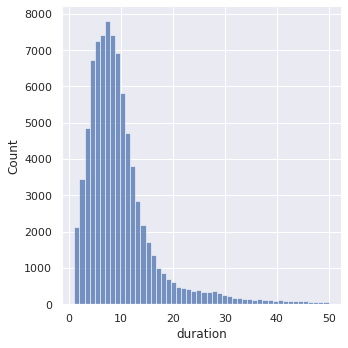

Simulation data


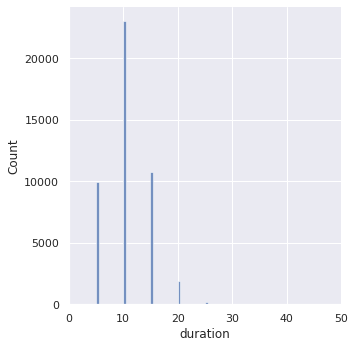

In [ ]:
xmax = 50

print('Real data')
tmp2 = tmp.copy()
tmp2 = tmp2[tmp2['duration']<=xmax]
sns.displot(tmp2['duration'], bins=50)
plt.show();

print('Simulation data')
sns.displot(history['duration'], bins=50)
plt.xlim([0,xmax])
plt.show();

In [ ]:
history['duration'].describe()

count    45901.000000
mean        10.577656
std          4.035271
min          5.000000
25%         10.000000
50%         10.000000
75%         15.000000
max         30.000000
Name: duration, dtype: float64

### Stations

**Frequency**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


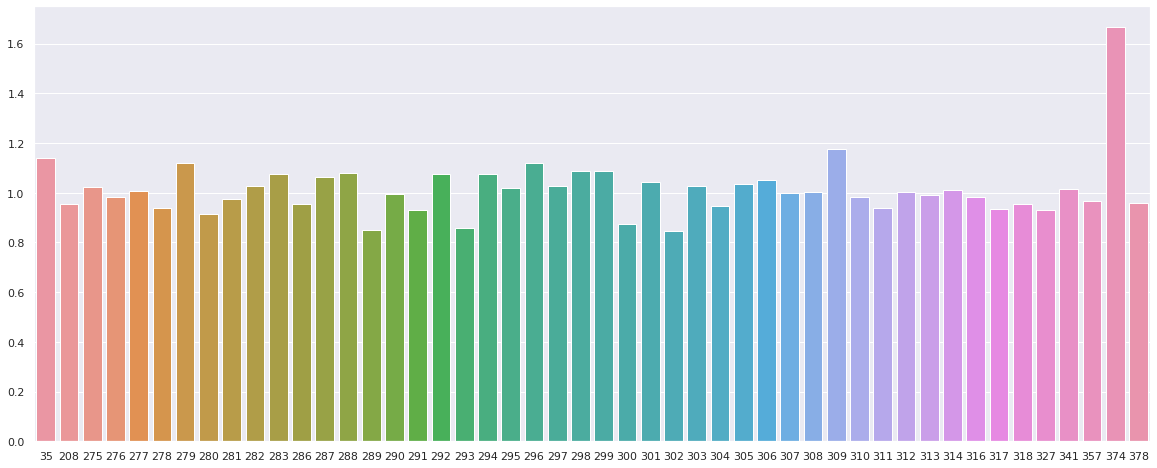

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


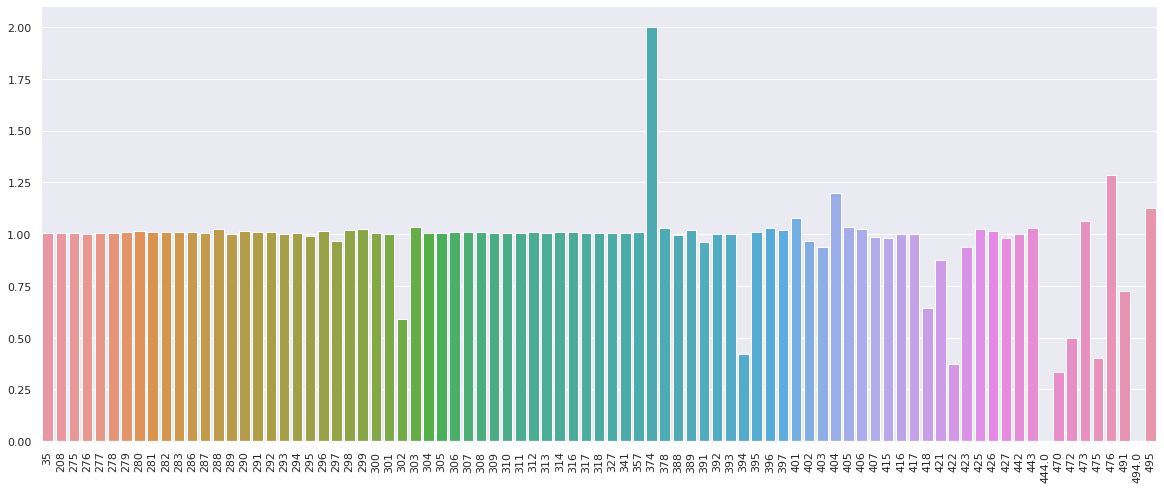

In [ ]:
x1 = pd.value_counts(real['id1'])
x2 = pd.value_counts(real['id2'])
x = x1.divide(x2, fill_value=0)
sns.barplot(x.index, list(x))
plt.show();

x1 = pd.value_counts(history['id1'])
x2 = pd.value_counts(history['id2'])
x = x1.divide(x2, fill_value=0)
sns.barplot(x.index, list(x))
plt.xticks(rotation=90)
plt.show();

real data


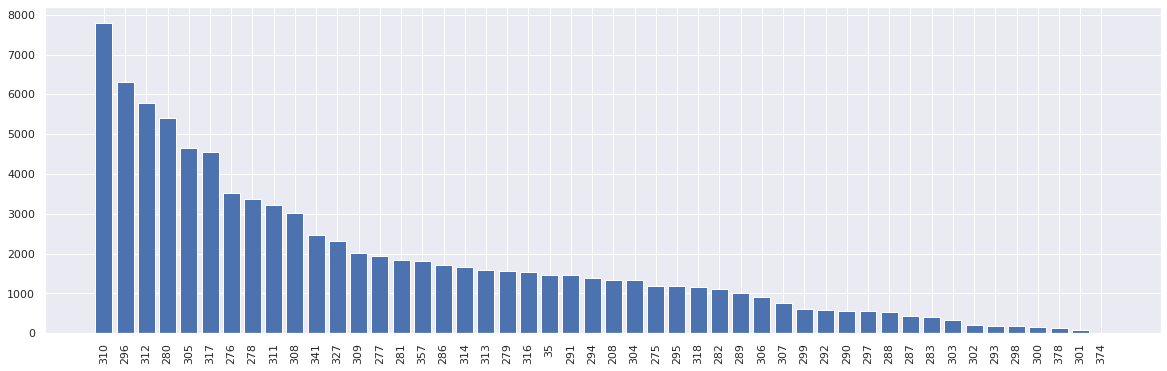

simulation data


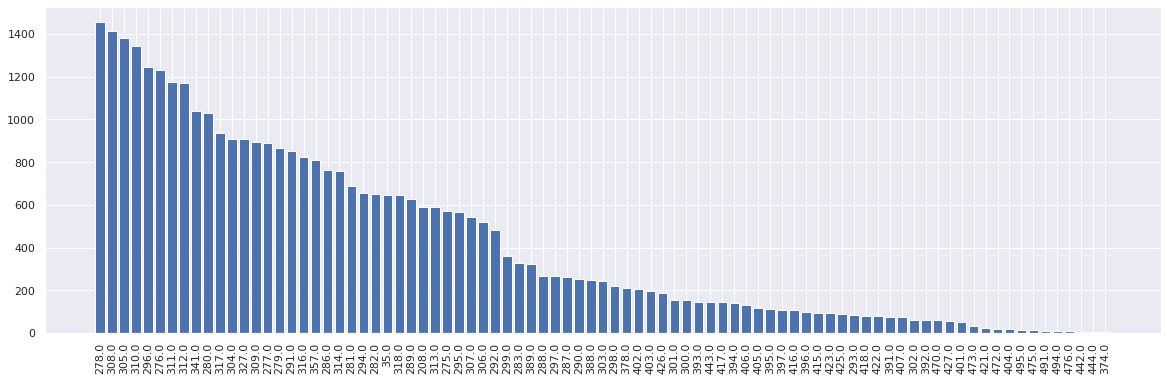

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)

print('real data')
x = pd.value_counts(real['id2'])
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('simulation data')
x = pd.value_counts(history['id2'])
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

Full / empty stations

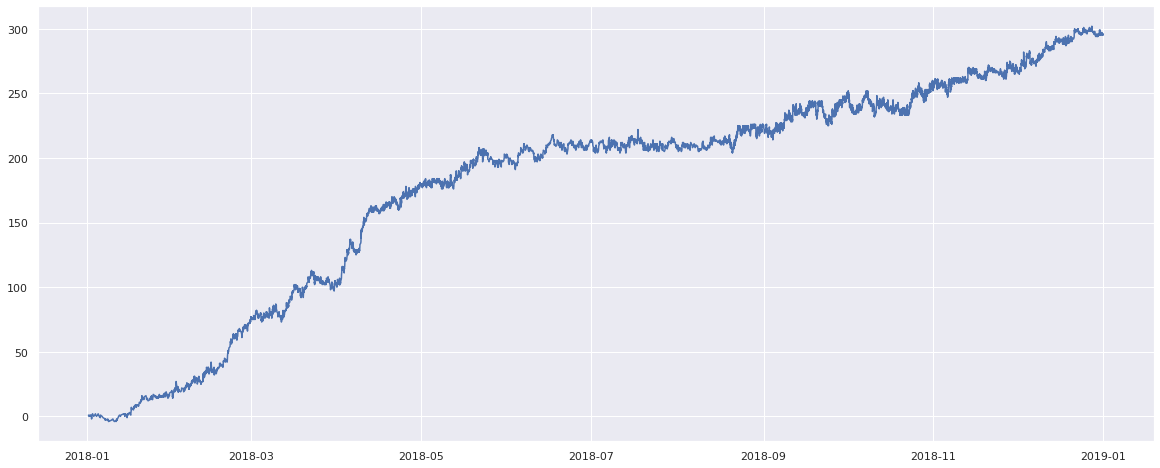

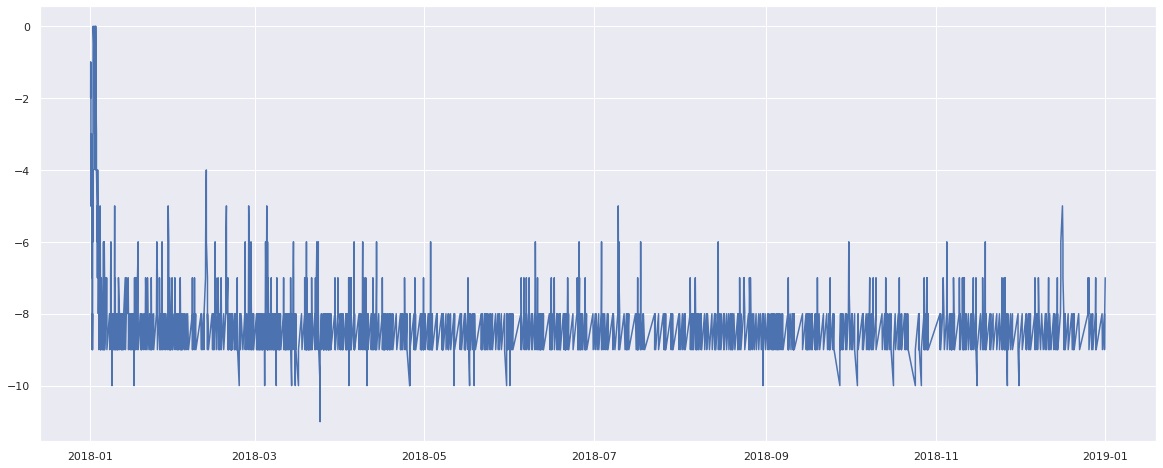

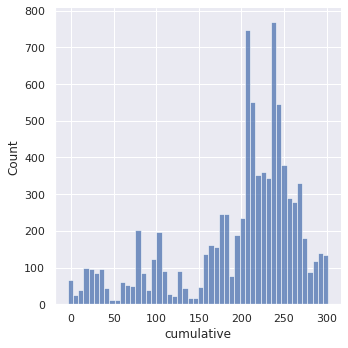

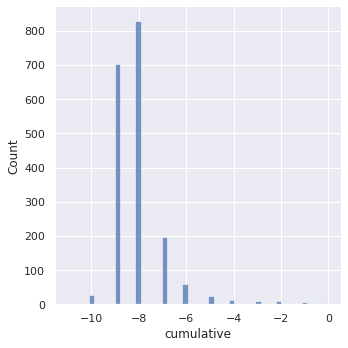

In [ ]:
def count_bikes_in_station(df, station_id):
  tmp1 = list(df[df['id1']==station_id]['time1'])
  c1 = [-1] * len(tmp1)

  tmp2 = list(df[df['id2']==station_id]['time2'])
  c2 = [1] * len(tmp2)

  tmp = pd.DataFrame({'time': tmp1+tmp2, 'type': c1+c2}).sort_values(by='time')
  tmp['cumulative'] = tmp['type'].cumsum()

  return tmp



cur = 317

#### commentino -> nei dati reali spesso succede che si va di molto sopra lo zero 
#### ===> suppongo che le bici vengono riposizionate dall'azienda dove serve, non ci possono mica essere centinaia di bici parcheggiate

tmp_real = count_bikes_in_station(real, cur)
tmp_sim = count_bikes_in_station(history, cur)

plt.plot(tmp_real['time'], tmp_real['cumulative'])
plt.show();
plt.plot(tmp_sim['time'], tmp_sim['cumulative'])
plt.show();

sns.displot(tmp_real['cumulative'], bins=50)
plt.show();
sns.displot(tmp_sim['cumulative'], bins=50)
plt.show();

### Bikes

**Frequency**

Real data
904 bikes


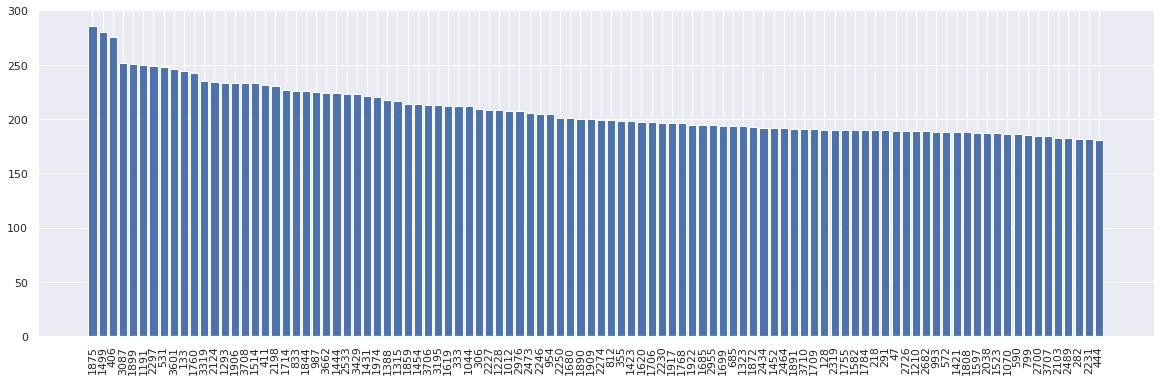

Simulation data
916 bikes


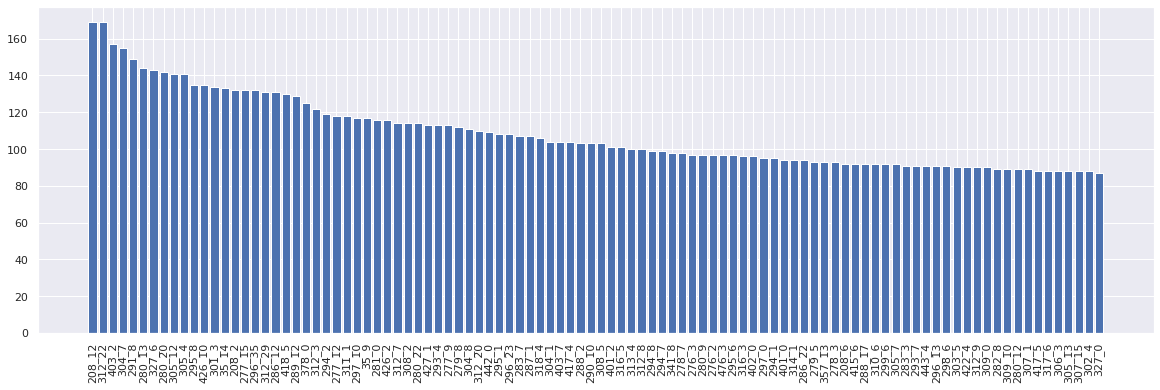

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)

print('Real data')
x = pd.value_counts(tmp['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

print('Simulation data')
x = pd.value_counts(history['bike_id'])
print(len(x), 'bikes')
x = x.head(100)
labels = [str(l) for l in x.index]
count = list(x)
plt.bar(labels, count)
plt.xticks(rotation=90)
plt.show();

**Single bike usage**

In [ ]:
# si può vedere quante ore è stata usata in totale, stimare i km percorsi, 
# quante bici hanno bisogno manutenzione? (cioè sono state usate oltre X km -> google dice ogni 2000/5000 km)

b = '208_12'
bike_history = history[history['bike_id']==b].copy()
print('bike', b, 'used for', np.sum(bike_history['duration']) / 60, 'hours')

bike 208_12 used for 30.75 hours


**Concurrent overall rides**

Real data


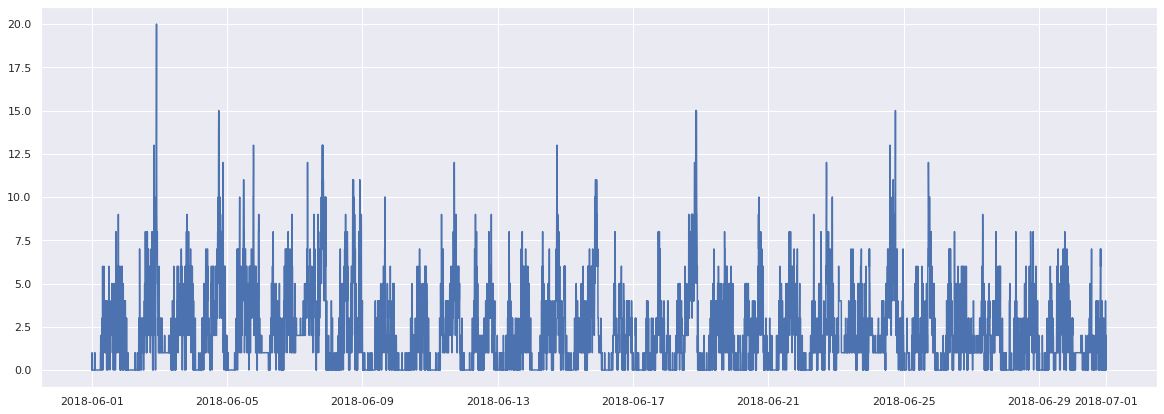

Simulation data


KeyboardInterrupt: ignored

In [ ]:
plt.rcParams["figure.figsize"] = (20,7)

print('Real data')
t = tmp[['time1', 'time2']].copy()
for c in t.columns:
  t[c] = pd.to_datetime(t[c])
count = []
times = []
i = start_date
while i < end_date:
  count.append(len(t[(t['time1']<=i) & (t['time2']>i)]))
  times.append(i)
  i += timedelta(minutes=GEN_UPDATE)
plt.plot(times, count)
plt.show();

print('Simulation data')
t = history[['time1', 'time2']].copy()
for c in t.columns:
  t[c] = pd.to_datetime(t[c])
count = []
times = []
i = start_date
while i < end_date:
  count.append(len(t[(t['time1']<=i) & (t['time2']>i)]))
  times.append(i)
  i += timedelta(minutes=GEN_UPDATE)
plt.plot(times, count)
plt.show();